<a href="https://colab.research.google.com/github/leyixu21/master_thesis/blob/main/get_flickr_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparations

In [14]:
! pip install flickrapi
! pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
from io import StringIO
from flickrapi import FlickrAPI
from urllib.request import urlretrieve
import os, time, sys
import json
import pandas as pd
import calendar
import time
import folium

import geopandas as gpd

In [ ]:
# set paths
path_grid='/content/drive/MyDrive/master_thesis_data/grids_london/'
path='/content/drive/MyDrive/master_thesis_data/'


# Greater London

## Automated Workflow (USE ONLY THIS SECTION!)

In [ ]:
# collect Flickr data within the defined bounding box (devided by grids)
# Source: https://fivequestionz.home.blog/2020/07/30/how-to-map-the-photo-location-of-flickr-using-python-and-qgis/

## Add your API Key and secret of Flickr
key = "0c15e34e5d1c5ed988c007ab2992ed25"
secret = "c43c334c97c11d2c"

# Span to access the flickr server
wait_time = 1

output_json = 'london_bbox_flickr_grid_'

keyword = sys.argv[1]

photos = []
l = 0
n= [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3]

# for y in [2012]: ## 10 years. You can change the years to collect photos from Flickr.
y = 2012
# devide the bounding box into grids to collect Flickr data
lats = [51.282739, 51.4, 51.5, 51.6, 51.700625]
lons = [-0.547481, -0.4, -0.35, -0.3, -0.275, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.363355]
grid_id = 0
# iterate every grid
for lat in range(len(lats)-1):
  for lon in range(len(lons)-1):
    bbox_sub = str(lons[lon]) + ',' + str(lats[lat]) + ',' + str(lons[lon+1]) + ',' + str(lats[lat+1])
    for k in [1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9,10,10,10,11,11,11,12,12,12]:
        m = k
        l = l+1
        print(l)
        
        days = calendar.monthrange(y,m)[1]
        
        if n[l-1] == 3:
            min_taken_date = str(y) + '-' + str(m) + '-21'
            max_taken_date = str(y) + '-' + str(m) + '-' + str(days)
            #reset I for the next year
            if m == 12:
                l = 0
        elif n[l-1] ==2:
            min_taken_date = str(y) + '-' + str(m) + '-11'
            max_taken_date = str(y) + '-' + str(m) + '-20'
        elif n[l-1] ==1:
            min_taken_date = str(y) + '-' + str(m) + '-01'
            max_taken_date = str(y) + '-' + str(m) + '-10'

        print('grid:'+str(grid_id))
        print('bbox:'+bbox_sub) 
        print(n[l-1])
        print(min_taken_date)
        print(max_taken_date)
        
        # connecting to Flickr
        flickr = FlickrAPI(key, secret, format='parsed-json')
        
        i = 1
        while True:
            result = flickr.photos.search(
                #text = 'your keyword',    #keyword change
                per_page = 400,            #number of data per page
                has_geo = 1,               #Photo that has geo location
                min_taken_date = min_taken_date, 
                max_taken_date = max_taken_date,
                #woe_id = 7153351, #7153351 # woeid does not work.
                # bbox = '-0.547481,51.282739,0.363355,51.700625',
                bbox = bbox_sub,
#Please change the here for your study area in the order. LonLL, LatLL, LonUR, LatUR. LL:Lower Left corner, UR:Upper Right corner
                media = 'photos',         # collecting photos without video
                sort =  'date-taken-desc',       # collecting photos from latest
                privacy_filter =1,
                safe_search = 1,          #  photos without violence
                extras = 'geo,url_n,date_taken,views, license, tags, machine_tags',
                page = i,
            )

            # export result
            # photos = ChainMap(photos, result['photos'])
            # photos = result['photos']
            j = result['photos']
            
            print('total_photo', j['total'])
            print('Current_pages', i)
            
            photos += j[ 'photo']
            # print(j)

            #you can download up to 4000 photos in one query.
            if i > 10 :
                print('Your query has been exceeded the limit of photos.4000 photos' + str(i))
                break
            elif i >= j['pages'] :
                break
            i += 1
          
    # export as Json format
    d = json.dumps(photos, sort_keys = True, indent = 2)
    #print(d)
    # fp = open(path+output_json+str(y)+'.json', 'w' )
    fp = open(path_grid+output_json+str(grid_id)+'_'+str(y)+'.json', 'w' )
    fp.write( d )
    fp.close()

    # export as csv
    df = pd.read_json (StringIO(d))
    df.to_csv(path_grid+output_json+str(grid_id)+'_'+str(y)+'.csv', encoding='utf-8')

    grid_id += 1
    time.sleep(10)



In [30]:
# merge the grids of Flickr data in the same year
# create a list to store the dataframe of each grid
frames = []
# iterate the grid
for i in range(68):
  df_grid = pd.read_csv(path+output_json+str(i)+'_'+str(y)+'.csv')
  frames.append(df_grid)

df = pd.concat(frames)

# save df as csv
output_bbox_csv = 'london_bbox_flickr_'
df.to_csv(path+output_bbox_csv+str(y)+'.csv', encoding='utf-8')

In [ ]:
# read boundary data
london = gpd.read_file(path+'london_boundaries.geojson')

# preprocess df and get data within the city boundary
from shapely import wkt
# convert string to datetime format
df['datetaken'] = pd.to_datetime(df['datetaken'], format='%Y-%m-%d %H:%M:%S')
# sort by datetaken
df = df.sort_values(by='datetaken')

# convert dataframe to geodataframe
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326')
)

# get Flickr data inside the city boundary
gdf = gdf[gdf.within(london.unary_union)]

output_csv = 'london_flickr_'

# save the Flickr data inside the city boundary as the geojson file
gdf.to_file(path+output_csv+str(y)+'.geojson')

## Collect Flickr Data

In [ ]:
path='/content/drive/MyDrive/master_thesis_data/'

In [ ]:
# Source: https://fivequestionz.home.blog/2020/07/30/how-to-map-the-photo-location-of-flickr-using-python-and-qgis/

## Add your API Key and secret of Flickr
key = "0c15e34e5d1c5ed988c007ab2992ed25"
secret = "c43c334c97c11d2c"

# Span to access the flickr server
wait_time = 1

output_json = 'london_bbox_flickr_'
 ## Please change the output file name

keyword = sys.argv[1]

photos = []
l = 0
##Loop start
n= [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3]
for y in [2021]: ## 10 years. You can change the years to collect photos from Flickr.

    for k in [1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9,10,10,10,11,11,11,12,12,12]:
        m = k
        l = l+1
        print(l)
        
        days = calendar.monthrange(y,m)[1]
        
        if n[l-1] == 3:
            min_taken_date = str(y) + '-' + str(m) + '-21'
            max_taken_date = str(y) + '-' + str(m) + '-' + str(days)
            #reset I for the next year
            if m == 12:
                l = 0
        elif n[l-1] ==2:
            min_taken_date = str(y) + '-' + str(m) + '-11'
            max_taken_date = str(y) + '-' + str(m) + '-20'
        elif n[l-1] ==1:
            min_taken_date = str(y) + '-' + str(m) + '-01'
            max_taken_date = str(y) + '-' + str(m) + '-10'
            
        print(n[l-1])
        print(min_taken_date)
        print(max_taken_date)
        
        # connecting to Flickr
        flickr = FlickrAPI(key, secret, format='parsed-json')
        
        i = 1
        while True:
            result = flickr.photos.search(
                #text = 'your keyword',    #keyword change
                per_page = 400,            #number of data per page
                has_geo = 1,               #Photo that has geo location
                min_taken_date = min_taken_date, 
                max_taken_date = max_taken_date,
                #woe_id = 7153351, #7153351 # woeid does not work.
                bbox = '-0.547481,51.282739,0.363355,51.700625',
#Please change the here for your study area in the order. LonLL, LatLL, LonUR, LatUR. LL:Lower Left corner, UR:Upper Right corner
                media = 'photos',         # collecting photos without video
                sort =  'date-taken-desc',       # collecting photos from latest
                privacy_filter =1,
                safe_search = 1,          #  photos without violence
                extras = 'geo,url_n,date_taken,views, license, tags, machine_tags',
                page = i,
            )

            # export result
            #photos = ChainMap(photos, result['photos'])
            #photos = result['photos']
            j = result['photos']
            
            print('total_photo', j['total'])
            print('Current_pages', i)
            
            photos += j[ 'photo']

            #you can download up to 4000 photos in one query.
            if i > 10 :
                print('Your query has been exceeded the limit of photos.4000 photos' + str(i))
                break
            elif i >= j['pages'] :
                break
            i += 1
            
# export as Json format
d = json.dumps(photos, sort_keys = True, indent = 2)
#print(d)
fp = open(path+output_json+str(y)+'.json', 'w' )
fp.write( d )
fp.close()

# export as csv
df = pd.read_json (StringIO(d))
df.to_csv(path+output_json+str(y)+'.csv', encoding='utf-8')

In [ ]:
from shapely import wkt
# read flickr data
london_bbox_flickr_2021 = pd.read_csv(path+'london_bbox_flickr_2021.csv')

# convert dataframe to geodataframe
london_bbox_flickr_2021 = gpd.GeoDataFrame(
    london_bbox_flickr_2021, geometry=gpd.points_from_xy(london_bbox_flickr_2021.longitude, london_bbox_flickr_2021.latitude, crs='epsg:4326')
)

london_bbox_flickr_2021

## Load Boundary Data

In [ ]:
# read boundary data
london = gpd.read_file(path+'statistical-gis-boundaries-london/ESRI/MSOA_2004_London_High_Resolution.shp')

london

,MSOA_CODE,MSOA_NAME,LA_CODE,LA_NAME,GEOEAST,GEONORTH,POPEAST,POPNORTH,AREA_KM2,geometry
0,E02000001,City of London 001,00AA,City of London,532464,181220,532458,181630,3.151470,"POLYGON ((532946.061 181894.832, 532946.070 18..."
1,E02000002,Barking and Dagenham 001,00AB,Barking and Dagenham,548313,189878,547997,189392,2.161570,"POLYGON ((548877.688 191097.328, 548877.680 19..."
2,E02000003,Barking and Dagenham 002,00AB,Barking and Dagenham,548456,188400,548377,188094,2.141520,"POLYGON ((548954.499 189063.200, 548889.701 18..."
3,E02000004,Barking and Dagenham 003,00AB,Barking and Dagenham,551010,186308,550921,186823,2.492950,"POLYGON ((551550.003 187364.637, 551549.995 18..."
4,E02000005,Barking and Dagenham 004,00AB,Barking and Dagenham,548666,186903,548707,186820,1.187950,"POLYGON ((549026.800 186159.802, 549014.498 18..."
...,...,...,...,...,...,...,...,...,...,...
978,E02000979,Westminster 020,00BK,Westminster,529692,179457,529512,179125,1.588550,"POLYGON ((530642.647 180416.875, 530642.581 18..."
979,E02000980,Westminster 021,00BK,Westminster,529921,178656,529758,178698,0.539208,"POLYGON ((530412.939 178957.723, 530412.873 17..."
980,E02000981,Westminster 022,00BK,Westminster,529123,178488,529140,178401,0.363777,"POLYGON ((529130.907 178927.842, 529134.963 17..."
981,E02000982,Westminster 023,00BK,Westminster,528658,178494,528657,178365,0.654287,"POLYGON ((529130.907 178927.842, 529130.997 17..."


In [ ]:
# convert the coordination system to wgs84
london = london.to_crs('epsg:4326')
london.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# create folium map
m = folium.Map(location=[51.501549, -0.126761], zoom_start=10, tiles='CartoDB positron')
for _, r in london.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['MSOA_NAME']).add_to(geo_j)
    geo_j.add_to(m)

m

In [ ]:
# get Flickr data inside the city boundary
london_flickr_2021 = london_bbox_flickr_2021[london_bbox_flickr_2021.within(london.unary_union)]

# save the Flickr data inside the city boundary as the geojson file
london_flickr_2021.to_file(path + 'london_flickr_2021.geojson')

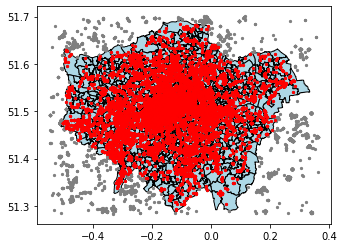

In [ ]:
# plot the boundary
base = london.plot(color='lightblue', edgecolor='black')

# plot the flickr data within the bounding box
london_bbox_flickr_2021.plot(ax=base, marker='o', color='grey', markersize=5)

# plot the flickr data within the bouondary
london_flickr_2021.plot(ax=base, marker='o', color='red', markersize=5)

# New York

## Collect Flickr Data

In [ ]:
path='/content/drive/MyDrive/master_thesis_data/newyork_zurich/'

# Source: https://fivequestionz.home.blog/2020/07/30/how-to-map-the-photo-location-of-flickr-using-python-and-qgis/

## Add your API Key and secret of Flickr
key = "0c15e34e5d1c5ed988c007ab2992ed25"
secret = "c43c334c97c11d2c"

# Span to access the flickr server
wait_time = 1

output_json = 'newyork_bbox_flickr_'
 ## Please change the output file name

keyword = sys.argv[1]

photos = []
l = 0
##Loop start
n= [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3]
for y in [2018]: ## 10 years. You can change the years to collect photos from Flickr.

    for k in [1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9,10,10,10,11,11,11,12,12,12]:
        m = k
        l = l+1
        print(l)
        
        days = calendar.monthrange(y,m)[1]
        
        if n[l-1] == 3:
            min_taken_date = str(y) + '-' + str(m) + '-21'
            max_taken_date = str(y) + '-' + str(m) + '-' + str(days)
            #reset I for the next year
            if m == 12:
                l = 0
        elif n[l-1] ==2:
            min_taken_date = str(y) + '-' + str(m) + '-11'
            max_taken_date = str(y) + '-' + str(m) + '-20'
        elif n[l-1] ==1:
            min_taken_date = str(y) + '-' + str(m) + '-01'
            max_taken_date = str(y) + '-' + str(m) + '-10'
            
        print(n[l-1])
        print(min_taken_date)
        print(max_taken_date)
        
        # connecting to Flickr
        flickr = FlickrAPI(key, secret, format='parsed-json')
        
        i = 1
        while True:
            result = flickr.photos.search(
                #text = 'your keyword',    #keyword change
                per_page = 400,            #number of data per page
                has_geo = 1,               #Photo that has geo location
                min_taken_date = min_taken_date, 
                max_taken_date = max_taken_date,
                woe_id = 7153351, #7153351 # woeid does not work.
                bbox = '-74.281672,40.480880,-73.661053,40.940826',
 #Please change the here for your study area in the order. LonLL, LatLL, LonUR, LatUR. LL:Lower Left corner, UR:Upper Right corner
                media = 'photos',         # collecting photos without video
                sort =  'date-taken-desc',       # collecting photos from latest
                # privacy_filter =1,
                safe_search = 1,          #  photos without violence
                extras = 'geo,url_n,date_taken,views, license, tags, machine_tags',
                page = i,
            )

            # export result
            #photos = ChainMap(photos, result['photos'])
            #photos = result['photos']
            j = result['photos']
            
            print('total_photo', j['total'])
            print('Current_pages', i)
            
            photos += j[ 'photo']

            #you can download up to 4000 photos in one query.
            if i > 10 :
                print('Your query has been exceeded the limit of photos.4000 photos' + str(i))
                break
            elif i >= j['pages'] :
                break
            i += 1
            
# export as Json format
d = json.dumps(photos, sort_keys = True, indent = 2)
#print(d)
fp = open(path+output_json+str(y)+'.json', 'w' )
fp.write( d )
fp.close()

# export as csv
df = pd.read_json (StringIO(d))
df.to_csv(path+output_json+str(y)+'.csv', encoding='utf-8')

In [ ]:
from shapely import wkt
# read flickr data
newyork_bbox_flickr_2021 = pd.read_csv(path+'newyork_bbox_flickr_2021.csv')

# convert dataframe to geodataframe
newyork_bbox_flickr_2021 = gpd.GeoDataFrame(
    newyork_bbox_flickr_2021, geometry=gpd.points_from_xy(newyork_bbox_flickr_2021.longitude, newyork_bbox_flickr_2021.latitude, crs='epsg:4326')
)

newyork_bbox_flickr_2021

,Unnamed: 0,accuracy,context,datetaken,datetakengranularity,datetakenunknown,farm,geo_is_contact,geo_is_family,geo_is_friend,...,place_id,secret,server,tags,title,url_n,views,width_n,woeid,geometry
670,670,16,0,2021-01-01 08:13:24,0,0,66,0,0,0,...,NaN,8c0e7f3dae,65535,newyorkcity newyork unitedstates,some classics in the pic,https://live.staticflickr.com/65535/5079780905...,82,320.0,8410791,POINT (-73.99413 40.75142)
777,777,16,0,2021-01-01 08:13:24,0,0,66,0,0,0,...,NaN,8c0e7f3dae,65535,newyorkcity newyork unitedstates,some classics in the pic,https://live.staticflickr.com/65535/5079780905...,82,320.0,8410791,POINT (-73.99413 40.75142)
450,450,16,0,2021-01-01 08:31:04,0,0,66,0,0,0,...,NaN,8e6788188f,65535,nyc yc manhattan newyear’sday centralpark lite...,Good Morning 2021,https://live.staticflickr.com/65535/5078692305...,334,240.0,5128594,POINT (-73.97148 40.77274)
58,58,16,0,2021-01-01 08:46:00,0,0,66,0,0,0,...,NaN,d71762b44e,65535,NaN,JPM and Milo at his breakfast bowl,https://live.staticflickr.com/65535/5086824407...,248,320.0,5112388,POINT (-73.99841 40.74222)
76,76,16,0,2021-01-01 09:24:40,0,0,66,0,0,0,...,NaN,e6b962c0f4,65535,filter used hasselblad 93 3x pl 15 lin carlzei...,DSC_8652_Hasselblad CarlZeiss Lens CF50mm 4/F,https://live.staticflickr.com/65535/5078726123...,656,320.0,5126855,POINT (-74.09149 40.56654)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20445,20445,16,0,2021-12-31 02:19:33,0,0,66,0,0,0,...,NaN,98d03de1e8,65535,NaN,NaN,https://live.staticflickr.com/65535/5181091678...,49,320.0,6944378,POINT (-73.97856 40.75304)
20435,20435,16,0,2021-12-31 12:26:10,0,0,66,0,0,0,...,NaN,9ec4bd0008,65535,nyc harlem construction,81 West 118th Street,https://live.staticflickr.com/65535/5179501674...,148,213.0,7177511,POINT (-73.94814 40.80310)
20223,20223,16,0,2021-12-31 12:44:22,0,0,66,0,0,0,...,NaN,6c027832d4,65535,nyc harlem construction,300 West,https://live.staticflickr.com/65535/5179868961...,112,213.0,7250810,POINT (-73.95361 40.80796)
20306,20306,16,0,2021-12-31 12:54:15,0,0,66,0,0,0,...,NaN,0054269396,65535,newyorkcity manhattan graphics poster miltongl...,Do Good Work - NYC,https://live.staticflickr.com/65535/5179029187...,131,249.0,8436476,POINT (-73.99519 40.74209)


## Load Boundary Data

In [ ]:
# read boundary data
newyork = gpd.read_file(path+'Borough Boundaries.geojson')

newyork

,boro_code,boro_name,shape_area,shape_leng,geometry
0,5,Staten Island,1623631283.36,325924.002076,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,2,Bronx,1187189499.3,463277.240478,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
2,1,Manhattan,636605816.437,359103.151368,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,3,Brooklyn,1934169228.83,728478.125489,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
4,4,Queens,3041397430.33,888238.562635,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [ ]:
# get the coordination system
newyork.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# create folium map
m = folium.Map(location=[40.70, -73.94], zoom_start=10, tiles='CartoDB positron')

for _, r in newyork.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['boro_name']).add_to(geo_j)
    geo_j.add_to(m)

m

In [ ]:
# get Flickr data inside the city boundary
newyork_flickr_2021 = newyork_bbox_flickr_2021[newyork_bbox_flickr_2021.within(newyork.unary_union)]

# save the Flickr data inside the city boundary as the geojson file
newyork_flickr_2021.to_file(path + 'newyork_flickr_2021.geojson')


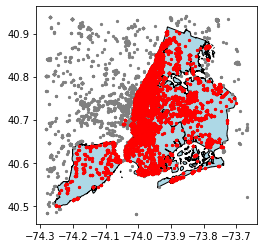

In [ ]:
# plot the boundary
base = newyork.plot(color='lightblue', edgecolor='black')

# plot the flickr data within the bounding box
newyork_bbox_flickr_2021.plot(ax=base, marker='o', color='grey', markersize=5)

# plot the flickr data within the bouondary
newyork_flickr_2021.plot(ax=base, marker='o', color='red', markersize=5)

# Zurich

## Collect Flickr Data

In [ ]:
path='/content/drive/MyDrive/master_thesis_data/newyork_zurich/'

# Source: https://fivequestionz.home.blog/2020/07/30/how-to-map-the-photo-location-of-flickr-using-python-and-qgis/

## Add your API Key and secret of Flickr
key = "0c15e34e5d1c5ed988c007ab2992ed25"
secret = "c43c334c97c11d2c"

# Span to access the flickr server
wait_time = 1

output_json = 'zurich_bbox_flickr_'
 ## Please change the output file name

keyword = sys.argv[1]

photos = []
l = 0
##Loop start
n= [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3]
# n= [1,2,3,1,2,3,1,2,3,1,2,3,1,2,3,1,2,3]

for y in [2021]: ## 10 years. You can change the years to collect photos from Flickr.

    for k in [1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9,10,10,10,11,11,11,12,12,12]:
    # for k in [7,7,7,8,8,8,9,9,9,10,10,10,11,11,11,12,12,12]:
        m = k
        l = l+1
        print(l)
        
        days = calendar.monthrange(y,m)[1]
        
        if n[l-1] == 3:
            min_taken_date = str(y) + '-' + str(m) + '-21'
            max_taken_date = str(y) + '-' + str(m) + '-' + str(days)
            #reset I for the next year
            if m == 12:
                l = 0
        elif n[l-1] ==2:
            min_taken_date = str(y) + '-' + str(m) + '-11'
            max_taken_date = str(y) + '-' + str(m) + '-20'
        elif n[l-1] ==1:
            min_taken_date = str(y) + '-' + str(m) + '-01'
            max_taken_date = str(y) + '-' + str(m) + '-10'
            
        print(n[l-1])
        print(min_taken_date)
        print(max_taken_date)
        
        # connecting to Flickr
        flickr = FlickrAPI(key, secret, format='parsed-json')
        
        i = 1
        while True:
            result = flickr.photos.search(
                #text = 'your keyword',    #keyword change
                per_page = 400,            #number of data per page
                has_geo = 1,               #Photo that has geo location
                min_taken_date = min_taken_date, 
                max_taken_date = max_taken_date,
                #woe_id = 7153351, #7153351 # woeid does not work.
                bbox = '8.435959,47.308864,8.632319,47.436570',
 #Please change the here for your study area in the order. LonLL, LatLL, LonUR, LatUR. LL:Lower Left corner, UR:Upper Right corner
                media = 'photos',         # collecting photos without video
                sort =  'date-taken-desc',       # collecting photos from latest
                privacy_filter =1,
                safe_search = 1,          #  photos without violence
                extras = 'geo,url_n,date_taken,views, license, tags, machine_tags',
                page = i,
            )

            # export result
            #photos = ChainMap(photos, result['photos'])
            #photos = result['photos']
            j = result['photos']
            
            print('total_photo', j['total'])
            print('Current_pages', i)
            
            photos += j[ 'photo']

            #you can download up to 4000 photos in one query.
            if i > 10 :
                print('Your query has been exceeded the limit of photos.4000 photos' + str(i))
                break
            elif i >= j['pages'] :
                break
            i += 1
            
# export as Json format
d = json.dumps(photos, sort_keys = True, indent = 2)
#print(d)
fp = open(path+output_json+str(y)+'.json', 'w' )
fp.write( d )
fp.close()

# export as csv
df = pd.read_json (StringIO(d))
df.to_csv(path+output_json+str(y)+'.csv', encoding='utf-8')

## Load Boundary Data

In [ ]:
# read boundary data
zurich = gpd.read_file(path+'zurich_boundary/data/stzh.adm_stadtkreise_a.json')

zurich

,objid,bezeichnung,name,entstehung,geometry
0,6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."
1,10,Kreis 11,11,4,"POLYGON ((8.55562 47.40129, 8.55581 47.40160, ..."
2,4,Kreis 9,9,4,"POLYGON ((8.50320 47.38100, 8.50308 47.38131, ..."
3,8,Kreis 2,2,4,"POLYGON ((8.52820 47.36885, 8.52761 47.36847, ..."
4,12,Kreis 10,10,4,"POLYGON ((8.50543 47.39495, 8.50546 47.39495, ..."
5,7,Kreis 3,3,4,"POLYGON ((8.52820 47.36885, 8.52798 47.36900, ..."
6,11,Kreis 12,12,4,"POLYGON ((8.58317 47.38830, 8.58315 47.38851, ..."
7,1,Kreis 6,6,4,"POLYGON ((8.55562 47.40129, 8.55543 47.40137, ..."
8,9,Kreis 8,8,6,"POLYGON ((8.55388 47.34086, 8.56442 47.34611, ..."
9,2,Kreis 4,4,1,"POLYGON ((8.52820 47.36885, 8.52901 47.36938, ..."


In [ ]:
# get the coordination system
zurich.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# create folium map
m = folium.Map(location=[47.35, 8.53], zoom_start=12, tiles='CartoDB positron')
for _, r in zurich.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(r['bezeichnung']).add_to(geo_j)
    geo_j.add_to(m)

m

In [ ]:
y = 2012
output_json = 'zurich_bbox_flickr_'

df = pd.read_csv(path+output_json+str(y)+'.csv')

# preprocess df and get data within the city boundary
from shapely import wkt
# convert string to datetime format
df['datetaken'] = pd.to_datetime(df['datetaken'], format='%Y-%m-%d %H:%M:%S')
# sort by datetaken
df = df.sort_values(by='datetaken')

# convert dataframe to geodataframe
df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326')
)

# get Flickr data inside the city boundary
df = df[df.within(zurich.unary_union)]

output_geojson = 'zurich_flickr_'

# save the Flickr data inside the city boundary as the geojson file
df.to_file(path+output_geojson+str(y)+'.geojson')

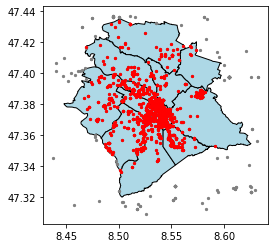

In [ ]:
# plot the boundary
base = zurich.plot(color='lightblue', edgecolor='black')

# plot the flickr data within the bounding box
zurich_bbox_flickr_2021.plot(ax=base, marker='o', color='grey', markersize=5)

# plot the flickr data within the bouondary
zurich_flickr_2021.plot(ax=base, marker='o', color='red', markersize=5)